In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, mixed_precision
from tensorflow.keras.layers import ReLU, LeakyReLU, Conv2D, Activation, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from pathlib import Path
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
import cv2 #pip install opencv-python
import numpy as np
from glob import glob 
from tensorflow.keras import backend as K
from contextlib import redirect_stdout
from tensorflow.keras.models import Model
import time
import random
from numba import njit

PATH = 'D:/Deletar/pictures_conv'
PATH_VAL = 'D:\\Deletar/pictures_conv\\validation'
PATH_VAL_OUT = 'D:\\Deletar\\pictures_conv\\validation_output'
""" PATH = 'C:/Deletar/pictures_conv'
PATH_VAL = 'C:\\Deletar/pictures_conv\\validation'
PATH_VAL_OUT = 'C:\\Deletar\\pictures_conv\\validation_output' """

tf.random.set_seed(42) 

LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
AdamL = 2e-5
AdamB = 0.5
generator_optimizer = tf.keras.optimizers.Adam(AdamL, beta_1 = AdamB)
discriminator_optimizer = tf.keras.optimizers.Adam(AdamL, beta_1 = AdamB)
HEIGHT = 1024
WIDTH = 1024
FILTERS = 128
KERNEL_SIZE = 3
STRIDES = 1
BATCH = 1
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 10
IMG_RANGE = 255.
PC = 1
IMAGES_TRAINING_SIZE = 100
IMAGES_TESTING_SIZE = 10
EPOCHS = 1
EPOCHS_PRINT = 20 # 20 default
MAX_LOOPS = 0 # if zero = max possible
OUTER_LOOPS = 100
SET_CHECKPOINT = False
EPOCHS_CHECK = 0 # 1,25/h per 100 epochs. If set to 0, will save in the final loop
TRAIN_ORDERED = True
MIXED_PRECISION = False
PRECISION = tf.float32
BYPASS_TRAIN = True

def get_all_info(folder):    
    imgs = []
    for file in os.listdir(folder):
        imgs.append(folder+file)
    return imgs

def split(arr, size):
    arrs = []
    while len(arr) > size:
        pice = arr[:size]
        arrs.append(pice)
        arr   = arr[size:]
    arrs.append(arr)
    return arrs

if (PC != 1):
    train_bw = get_all_info("C:\\Deletar\\pictures_conv\\train_new\\bw\\")
    train_bw = split(train_bw,IMAGES_TRAINING_SIZE)
    train_color = get_all_info("C:\\Deletar\\pictures_conv\\train_new\\color\\")
    train_color = split(train_color,IMAGES_TRAINING_SIZE)
    test_bw = get_all_info("C:\\Deletar\\pictures_conv\\test_new\\bw\\")
    test_bw = split(test_bw,IMAGES_TESTING_SIZE)
    test_color = get_all_info("C:\\Deletar\\pictures_conv\\test_new\\color\\")
    test_color = split(test_color,IMAGES_TESTING_SIZE)
    """ file_01 = "C:\\Deletar\\pictures_conv\\01.jpg" """
    eval_imgs = glob("C:\\Deletar\\pictures_conv\\*.jpg")
else:
    train_bw = get_all_info("D:\\Deletar\\pictures_conv\\train_new\\bw\\")
    train_bw = split(train_bw,IMAGES_TRAINING_SIZE)
    train_color = get_all_info("D:\\Deletar\\pictures_conv\\train_new\\color\\")
    train_color = split(train_color,IMAGES_TRAINING_SIZE)
    test_bw = get_all_info("D:\\Deletar\\pictures_conv\\test_new\\bw\\")
    test_bw = split(test_bw,IMAGES_TESTING_SIZE)
    test_color = get_all_info("D:\\Deletar\\pictures_conv\\test_new\\color\\")
    test_color = split(test_color,IMAGES_TESTING_SIZE)
    # file_01 = "D:\\Deletar\\pictures_conv\\01.jpg"
    eval_imgs = glob("D:\\Deletar\\pictures_conv\\*.jpg")

if MAX_LOOPS == 0:
    MAX_LOOPS = len(train_bw)

""" if MIXED_PRECISION == True:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    PRECISION = tf.float32
else:
    PRECISION = tf.float32 """



if EPOCHS_CHECK == 0:
    EPOCHS_CHECK = len(train_bw)-1
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# apply black and white colors to image

def apply_gauss_and_sharpen(img):    
    blur = cv2.GaussianBlur(img,(5,5),0)
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    image_sharp = cv2.filter2D(src=blur, ddepth=-1, kernel=kernel)
    return image_sharp

def apply_bw(filename):
    img = plt.imread(filename)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Input IMG is RGB
    img = cv2.merge([img,img,img])
    return img

def resize_image2(data):
    resized_img = tf.image.resize(
    images=K,
    size=[HEIGHT, WIDTH],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=True,
    )    
    return resized_img

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)    
    img = tf.image.convert_image_dtype(img, PRECISION)
    return img

def process_img2(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = apply_gauss_and_sharpen(img.numpy())
    img = tf.image.convert_image_dtype(img, PRECISION)
    img = tf.image.resize(img, size=(HEIGHT, WIDTH), antialias=True,method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,)
    return img

# read img and transform into tensor image
def read_img(filename):
    img = plt.imread(filename)
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])
    img = tf.convert_to_tensor(img/IMG_RANGE, dtype=PRECISION)
    return img

files_ds = []

tensor_img = np.zeros([16,BATCH,WIDTH,HEIGHT,3])

def random_crop(x, y):
  stacked_image = tf.stack([x, y], axis=0)
  cropped_image = tf.image.random_crop(
    #æ stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    stacked_image, size=[2, WIDTH, HEIGHT, 3])
  return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  #æ  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image = tf.image.resize(input_image, [WIDTH*2, HEIGHT*2],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  real_image = tf.image.resize(real_image, [WIDTH*2, HEIGHT*2],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

cont = 0
for image in eval_imgs:
    if cont < 4:
        image = process_img2(image)
        tensor_img[cont] = tf.expand_dims(image, axis=0)
        cont = cont + 1

In [4]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model
    
    def on_epoch_end(self, epoch, logs={}, ):
      example2 = list(files_ds.as_numpy_iterator())
      img_pred0 = self.model.predict(tensor_img[0])
      img_pred1 = self.model.predict(tensor_img[1])
      img_pred2 = self.model.predict(tensor_img[2])
      img_pred3 = self.model.predict(tensor_img[3])
      test_img_pred = (self.model.predict(example2[0][0]))[0]
      f, axarr = plt.subplots(1,6, figsize=(15, 7), constrained_layout=True, sharex=True, sharey=True)
      axarr[0].imshow(example2[0][1][0])
      axarr[1].imshow(test_img_pred)
      axarr[2].imshow(img_pred0[0])
      axarr[3].imshow(img_pred1[0])
      axarr[4].imshow(img_pred2[0])
      axarr[5].imshow(img_pred3[0]) 
      plt.show()



def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

In [5]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[HEIGHT, WIDTH, 3])

  """ down_stack = [
    downsample(128, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(256, 4),  # (batch_size, 64, 64, 128)
    downsample(512, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
  ]


  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 64, 64, 256)
    upsample(512, 4),  # (batch_size, 64, 64, 256)
    upsample(512, 4),  # (batch_size, 64, 64, 256)    
    upsample(256, 4),  # (batch_size, 64, 64, 256)
    upsample(128, 4),  # (batch_size, 128, 128, 128)
  ] """

  down_stack = [
    downsample(256, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(256, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(256, 4),  # (batch_size, 64, 64, 256)
    upsample(256, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  """ if MIXED_PRECISION == True:
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            dtype='float32',
                                            activation='sigmoid')  # (batch_size, 256, 256, 3) 
  else: """
     
  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[HEIGHT, WIDTH, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[HEIGHT, WIDTH, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()


def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [6]:
def print_results():
  example2 = list(files_ds.as_numpy_iterator())
  img_pred0 = generator(tensor_img[0], training=True)
  img_pred1 = generator(tensor_img[1], training=True)
  img_pred2 = generator(tensor_img[2], training=True)
  img_pred3 = generator(tensor_img[3], training=True)
  test_img_pred = generator(example2[0][0], training=True)
  f, axarr = plt.subplots(1,6, figsize=(15, 7), constrained_layout=True, sharex=True, sharey=True)
  axarr[0].imshow(example2[0][1][0])
  axarr[1].imshow(test_img_pred[0])
  axarr[2].imshow(img_pred0[0])
  axarr[3].imshow(img_pred1[0])
  axarr[4].imshow(img_pred2[0])
  axarr[5].imshow(img_pred3[0]) 
  plt.show()

In [7]:
@tf.function
def train_step(input_image, target, step=0):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
  
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  return gen_total_loss, disc_loss

""" with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000) """

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [8]:
cont_outer = 0
loss_gen_value = 4.4
loss_discr_value = 0.009
print('0%')
if TRAIN_ORDERED == True:
    for j in range(OUTER_LOOPS):
        print(f"{cont_outer} of {OUTER_LOOPS}")
        for i in range(len(train_bw)):
            if i < MAX_LOOPS:                        
                files_ds = tf.data.Dataset.from_tensor_slices((train_bw[i], train_color[i]))
                """ files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH).shuffle(BUFFER_SIZE) """
                files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y)))
                files_ds = files_ds.map(lambda x, y: random_jitter(x,y)).batch(BATCH).shuffle(BUFFER_SIZE)     

                val_files = tf.data.Dataset.from_tensor_slices((test_bw[i], test_color[i]))
                val_files = val_files.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)
                """ if cont_outer % EPOCHS_PRINT == 0:  """
                start = time.time()              
                """ model.fit(files_ds,epochs=EPOCHS, callbacks=[CustomCallback(model, files_ds)], validation_data=val_files, verbose=1) """
                for x,y in files_ds:
                    loss, loss_discr = train_step(x,y)
                    """ if (tf.constant(loss) < loss_gen_value):
                        print(loss)
                        checkpoint.save(file_prefix=checkpoint_prefix)
                        loss_gen_value = tf.constant(loss) """
                """ print(tf.constant(loss))
                if (tf.constant(loss) < MAX_LOSS and SET_CHECKPOINT == True):                
                    checkpoint.save(file_prefix=checkpoint_prefix)
                    MAX_LOSS = tf.constant(loss)
                    print('foi') """
                end = time.time()
                if i % EPOCHS_PRINT == 0:
                    print_results()
                    print(f"{(cont_outer+1)/len(train_bw)*100/OUTER_LOOPS}% - {int(end-start)*EPOCHS_PRINT}s")
                else:
                    print(".", end = '')  
                """ if i > 0 and i % EPOCHS_CHECK == 0 and SET_CHECKPOINT == True:
                    checkpoint.save(file_prefix=checkpoint_prefix)  """
                if i > 0 and i % EPOCHS_CHECK == 0 and SET_CHECKPOINT == True:
                    checkpoint.save(file_prefix=checkpoint_prefix)   
                cont_outer = cont_outer + 1
else:
    bat_order = random.randint(0, len(train_bw)-1)
    img_order = random.randint(0, IMAGES_TRAINING_SIZE-1)
    files_ds = tf.data.Dataset.from_tensor_slices((train_bw[bat_order], train_color[bat_order]))
    files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH).shuffle(BUFFER_SIZE)
    val_files = tf.data.Dataset.from_tensor_slices((test_bw[bat_order], test_color[bat_order]))
    val_files = val_files.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)
    if BYPASS_TRAIN == False:
        for x,y in files_ds:                
                loss, loss_discr = train_step(x,y)
                print(tf.constant(loss), tf.constant(loss_discr))
                """ if (tf.constant(loss) < loss_gen_value): """
                """ if (tf.constant(loss_discr) < loss_discr_value):
                    checkpoint.save(file_prefix=checkpoint_prefix)
                    loss_discr_value = tf.constant(loss_discr) """


0%
0 of 100


KeyboardInterrupt: 

1/1 [==============================] - 0s 61ms/step


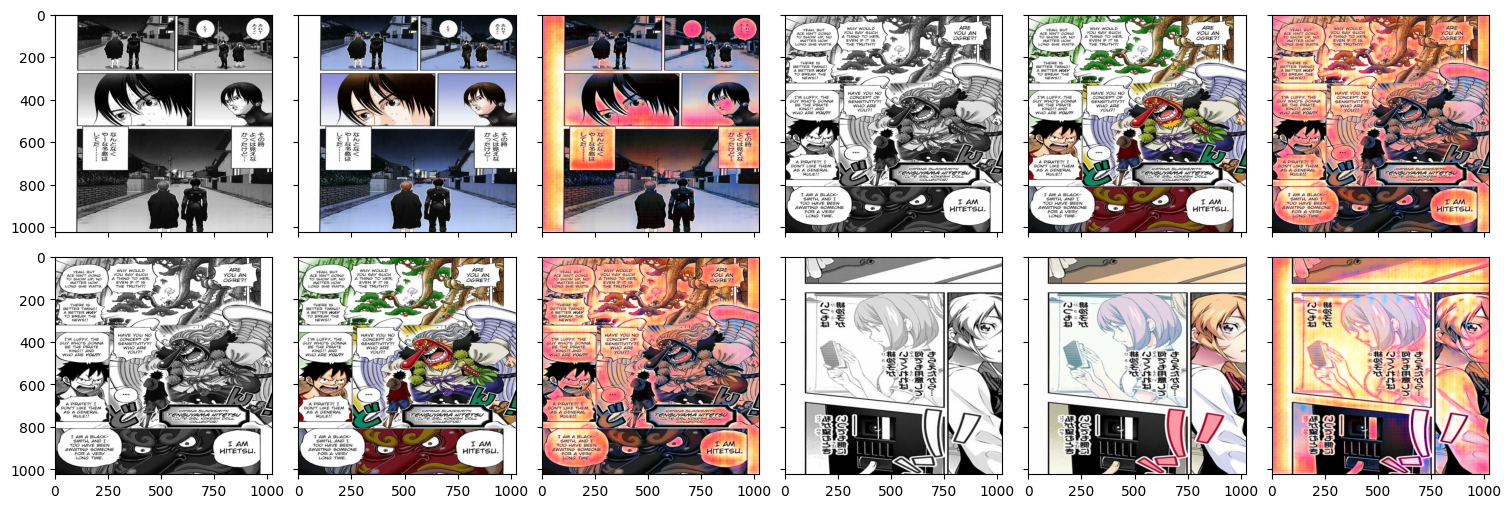

In [ ]:
example = list(files_ds.as_numpy_iterator())
example2 = list(val_files.as_numpy_iterator())

r_img1 = random.randint(0, len(example2)-1)
r_img2 = random.randint(0, len(example2)-1)
r_img3 = random.randint(0, len(example2)-1)
r_img4 = random.randint(0, len(example)-1)

test_img_pred = generator.predict(example2[r_img1][0])[0]
test_img_pred2 = generator.predict(example2[r_img2][0])[0]
test_img_pred3 = generator.predict(example2[r_img3][0])[0]
train_img_pred = generator.predict(example[r_img4][0])[0]

f, axarr = plt.subplots(2,6, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)
axarr[0,0].imshow(example2[r_img1][0][0])
axarr[0,1].imshow(example2[r_img1][1][0])
axarr[0,2].imshow(test_img_pred)
axarr[0,3].imshow(example2[r_img2][0][0])
axarr[0,4].imshow(example2[r_img2][1][0])
axarr[0,5].imshow(test_img_pred2)

axarr[1,0].imshow(example2[r_img3][0][0])
axarr[1,1].imshow(example2[r_img3][1][0])
axarr[1,2].imshow(test_img_pred3)
axarr[1,3].imshow(example[r_img4][0][0])
axarr[1,4].imshow(example[r_img4][1][0])
axarr[1,5].imshow(train_img_pred)

In [ ]:
@njit    
def verify_black(im):
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            r,g,b = im[x,y]
            if r*255 < 80 and g*255 < 80 and b*255 < 80:                
                im[x,y] = [0,0,0]
            else:
                im[x,y] = [1,1,1]
    return im 

@njit    
def merge_img(im1,im2):
    
    for x in range(im1.shape[0]):
        for y in range(im1.shape[1]):
            r,g,b = im1[x,y]
            if r != 0:
                
                r2,g2,b2 = im2[x,y] 
                im1[x,y] = [r2,g2,b2]
            """ else: """
               
            """ r,g,b = im2[x,y]
            img_out[x,y] = [r,g,b] """
    return  im1


def get_pred(filename):
    img = read_img(os.path.join(PATH_VAL,filename))    
    w = img.get_shape()[0] 
    h = img.get_shape()[1]
    """ img = resize_image2(os.path.join(PATH_VAL,filename)) """
    img = apply_gauss_and_sharpen(img.numpy())
    """ im_black = verify_black(img.numpy())   """  
    """ img = tf.image.resize(img,size=[HEIGHT,WIDTH]) """
    img = tf.image.resize(img,size=[HEIGHT,WIDTH])    
    img = tf.expand_dims(img, axis=0)
    img = generator(img, training=False)
    res = tf.image.resize(img[0],size=[w,h], antialias=True)
    
    """ print = merge_img(im_black, print.numpy()) """
    """ res = merge_img(im_black, img[0]) """
    """ res = merge_img(im_black, res.numpy())  """   
    
    tf.keras.preprocessing.image.save_img(os.path.join(PATH_VAL_OUT,filename), res)
    return img[0]



img_arr = []

for filename in os.listdir(os.path.join(PATH_VAL)):    
    img_arr.append(get_pred(filename))
        



""" external_img = 'G:\\Deletar\\pictures_conv\\01.jpg'
z = plt.imread(external_img)/255. """

""" z = read_img("G:\\Deletar\\pictures_conv\\01.jpg") """

""" try:
    z =  tf.image.rgb_to_grayscale(z)
except:
    z =  tf.expand_dims(tf.convert_to_tensor(z), axis=2)

z = np.concatenate((z,z,z),axis=-1) """

""" z = tf.image.resize(z,size=[HEIGHT,WIDTH])
z = tf.expand_dims(z, axis=0)
start = time.time_ns()
prediction = generator(z, training=True)
end = time.time_ns()
prediction = tf.image.resize(prediction[0],size=[1024,1024], antialias=True)

print(f"{int(end-start)/1000000}ms")
tf.keras.preprocessing.image.save_img('G:\\Deletar\\pictures_conv\\old\\01.jpg', prediction)
plt.imshow(prediction) """

' z = tf.image.resize(z,size=[HEIGHT,WIDTH])\nz = tf.expand_dims(z, axis=0)\nstart = time.time_ns()\nprediction = generator(z, training=True)\nend = time.time_ns()\nprediction = tf.image.resize(prediction[0],size=[1024,1024], antialias=True)\n\nprint(f"{int(end-start)/1000000}ms")\ntf.keras.preprocessing.image.save_img(\'G:\\Deletar\\pictures_conv\\old\\01.jpg\', prediction)\nplt.imshow(prediction) '